## Threshold for Closest School Dummies

Previously, we've seen some improvements over both the "Proposed" and "Eric" models when introducing a dummy variable for the closest school to each students' home zone. In this notebook, we explore whether including this dummy only for distances under a certain threshold can further improve our results.

First, let's load the data.

In [11]:
# Import necessary packages
import pandas as pd
from math import log

# Load data
df = pd.read_csv('../../Data/SMTO_2015/Formatted.csv')

# Convert school column to numeric
school_codes = df['School'].unique().tolist()
df['School'] = df['School'].apply(school_codes.index)

# Enrollment columns based on student's level
for code in school_codes:
    df['Enrol.' + code] = df.apply(lambda x: log(x[x.Level + '.' + code]), axis=1)
    
num_rows = df.shape[0]

Now, we define several useful functions for calculating metrics.

In [2]:
# Function for confusion matrices
def get_cm(probs, hardmax):
    cm = []
    if hardmax:
        for school in range(len(school_codes)):
            cm.append([(probs[df['School'] == school].idxmax(axis=1) == 'Prob.' + j).sum() for j in school_codes])
    else:
        for school in range(len(school_codes)):
            cm.append((probs[df['School'] == school][['Prob.' + i for i in school_codes]].sum().values.tolist()))    
    return cm

# Function for accuracy from confusion matrix
def get_accuracy(cm):
    correct = sum([cm[i][i] for i in range(len(cm))])
    return correct/sum(sum(cm,[])) * 100

Now, we iterate over possible threshold values and store the metrics for each model. We begin with the Eric model since this will allow us to examine the results for statistical significance of the closest dummy for different schools.

In [14]:
# Prepare lists for graphing
import numpy as np
ts = [150] + list(np.arange(30, 10, -5)) + list(np.arange(10, 4, -1)) + list(np.arange(4.5, -0.5, -0.5))
num_closests, ACCs, APOs = [], [], []

# Import Biogeme modules
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
from biogeme.expressions import Beta

# Iterate over thresholds
for t in ts:
    print(t)
    # Prepare dummy columns
    for code in school_codes:
        df['Closest.' + code] = ((df['Closest.' + code]) & (df['Dist.' + code] <= t)) * 1
    num_closests.append(df[['Closest.' + code for code in school_codes]].sum().sum()) 
    database = db.Database("SMTO", df.select_dtypes(include = 'number'))
    
    # Specify model
    ASCs, B_CLOSESTs, V, av = [], [], {}, {}
    B_DIST = Beta('B_DIST', 0, None, None, 0)
    B_FAM_DIST = Beta('B_FAM_DIST', 0, None, None, 0)
    for i in range(len(school_codes)):
        code = school_codes[i]
        ASCs.append(Beta('ASC_' + code, 0, None, None, 0 if code != 'SG' else 1))
        B_CLOSESTs.append(Beta('B_CLOSEST_' + code, 0, None, None, 0))
        V[i] = ASCs[i] + B_CLOSESTs[i] * database.variables["Closest." + code] + database.variables["Enrol." + code] + database.variables['Dist.' + code] * (B_DIST + B_FAM_DIST * database.variables["Family"])
        av[i] = 1   
    
    # Run model
    logprob = models.loglogit(V, av, database.variables["School"])
    biogeme = bio.BIOGEME(database, {'loglike': logprob, 'weight': database.variables["Exp_Factor"]})
    biogeme.modelName = "Eric_Closest_7_T=" + str(t)
    betas = biogeme.estimate().getBetaValues()    
    
    # Generate probabilities
    simulate = {'Prob.' + school_codes[i]: models.logit(V, av, i) for i in range(len(school_codes))}
    sim_biogeme = bio.BIOGEME(database, simulate)
    probs = sim_biogeme.simulate(betas).set_index(df.index)

    # Confusion matrices and metrics
    hard_cm = get_cm(probs, True)
    soft_cm = get_cm(probs, False)
    ACCs.append(get_accuracy(hard_cm))
    APOs.append(get_accuracy(soft_cm))

150
30
25
20
15
10
9
8
7
6
5
4.5
4.0
3.5
3.0
2.5
2.0
1.5
1.0
0.5
0.0


First, let's plot the number of students for which the closest dummy is included for each threshold.

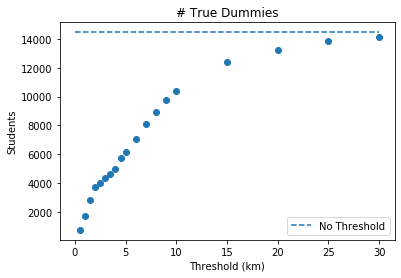

In [15]:
import matplotlib.pyplot as plt
plt.scatter(ts[1:-1], num_closests[1:-1])
plt.plot([0,  30], [num_rows, num_rows], '--')
plt.title("# True Dummies")
plt.xlabel('Threshold (km)')
plt.ylabel('Students')
plt.legend(labels = ['No Threshold'])
plt.show()

Now, let's plot the hardmax accuracies and softmax APOs for different thresholds.

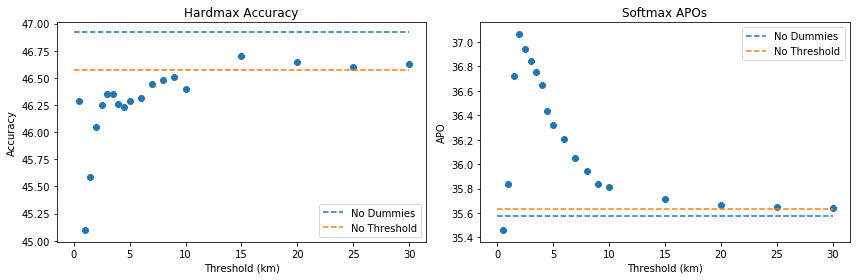

In [17]:
plt.subplots(1, 2, figsize=(12, 4))

# Plot hardmax accuracies
plt.subplot(1, 2, 1)
plt.scatter(ts[1:-1], ACCs[1:-1])
plt.plot([0, 30], [ACCs[-1], ACCs[-1]], '--')
plt.plot([0, 30], [ACCs[0], ACCs[0]], '--')
plt.title("Hardmax Accuracy")
plt.xlabel('Threshold (km)')
plt.ylabel('Accuracy')
plt.legend(labels = ['No Dummies', 'No Threshold'])

# Plot softmax APOs
plt.subplot(1, 2, 2)
plt.scatter(ts[1:-1], APOs[1:-1])
plt.plot([0, 30], [APOs[-1], APOs[-1]], '--')
plt.plot([0, 30], [APOs[0], APOs[0]], '--')
plt.title("Softmax APOs")
plt.xlabel('Threshold (km)')
plt.ylabel('APO')
plt.legend(labels = ['No Dummies', 'No Threshold'])

plt.tight_layout()
plt.show()

It seems that the best performing model is the one with a threshold of 2km. Let's look at the estimated parameters.

In [18]:
from IPython.display import HTML

best_threshold = 2
HTML(filename= "Eric_Closest_7_T=" + str(best_threshold) + ".html")

Report file:,Eric_Closest_7_T=2.html
Database name:,SMTO
Number of estimated parameters:,15
Sample size:,14478
Excluded observations:,0
Init log likelihood:,-23235.09
Final log likelihood:,-19112.95
Likelihood ratio test for the init. model:,8244.281
Rho-square for the init. model:,0.177
Rho-square-bar for the init. model:,0.177
Akaike Information Criterion:,38255.9


As we can see, all of the `B_CLOSEST` coefficients are positive and mostly statistically significant. This is encouraging!

Now, let's check if we obtain similar results for the proposed model, where only one `B_CLOSEST` is estimated for all seven campuses. We need to first reload the data.

In [19]:
df = pd.read_csv('../../Data/SMTO_2015/Formatted.csv')
school_codes = df['School'].unique().tolist()
df['School'] = df['School'].apply(school_codes.index)
for code in school_codes:
    df['Enrol.' + code] = df.apply(lambda x: log(x[x.Level + '.' + code]), axis=1)

Now let's run the model.

In [22]:
ACCs, APOs = [], []

for t in ts:
    # Prepare dummy columns
    for code in school_codes:
        df['Closest.' + code] = ((df['Closest.' + code]) & (df['Dist.' + code] <= t)) * 1
    database = db.Database("SMTO", df.select_dtypes(include = 'number'))
    
    # Specify model
    V, av = {}, {}
    B_DIST = Beta('B_DIST', 0, None, None, 0)
    B_CLOSEST = Beta('B_CLOSEST', 0, None, None, 0)
    B_FAM_DIST = Beta('B_FAM_DIST', 0, None, None, 0)
    B_ENROL = Beta('B_ENROL', 1, None, None, 0)
    for i in range(len(school_codes)):
        code = school_codes[i]
        V[i] = B_CLOSEST * database.variables["Closest." + code] + B_ENROL * database.variables["Enrol." + code] + database.variables['Dist.' + code] * (B_DIST + B_FAM_DIST * database.variables["Family"])
        av[i] = 1    
    
    # Run model
    logprob = models.loglogit(V, av, database.variables["School"])
    biogeme = bio.BIOGEME(database, {'loglike': logprob, 'weight': database.variables["Exp_Factor"]})
    biogeme.modelName = "Prop_Closest_7_T=" + str(t)
    betas = biogeme.estimate().getBetaValues()    
    
    print(t)
    
    # Generate probabilities
    simulate = {'Prob.' + school_codes[i]: models.logit(V, av, i) for i in range(len(school_codes))}
    sim_biogeme = bio.BIOGEME(database, simulate)
    probs = sim_biogeme.simulate(betas).set_index(df.index)

    # Confusion matrices and metrics
    hard_cm = get_cm(probs, True)
    soft_cm = get_cm(probs, False)
    ACCs.append(get_accuracy(hard_cm))
    APOs.append(get_accuracy(soft_cm))

150
30
25
20
15
10
9
8
7
6
5
4.5
4.0
3.5
3.0
2.5
2.0
1.5
1.0
0.5
0.0


Now, let's plot the hardmax accuracies and softmax APOs for different thresholds.

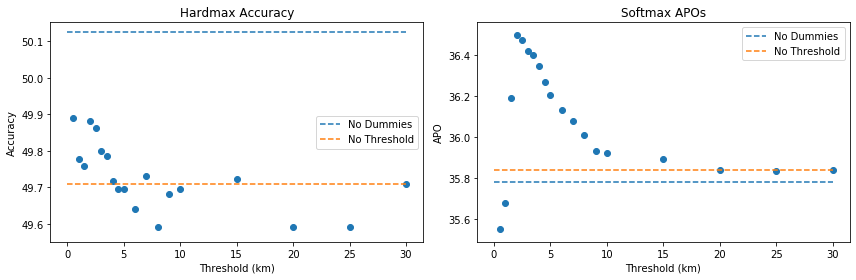

In [23]:
plt.subplots(1, 2, figsize=(12, 4))

# Plot hardmax accuracies
plt.subplot(1, 2, 1)
plt.scatter(ts[1:-1], ACCs[1:-1])
plt.plot([0, 30], [ACCs[-1], ACCs[-1]], '--')
plt.plot([0, 30], [ACCs[0], ACCs[0]], '--')
plt.title("Hardmax Accuracy")
plt.xlabel('Threshold (km)')
plt.ylabel('Accuracy')
plt.legend(labels = ['No Dummies', 'No Threshold'])

# Plot softmax APOs
plt.subplot(1, 2, 2)
plt.scatter(ts[1:-1], APOs[1:-1])
plt.plot([0, 30], [APOs[-1], APOs[-1]], '--')
plt.plot([0, 30], [APOs[0], APOs[0]], '--')
plt.title("Softmax APOs")
plt.xlabel('Threshold (km)')
plt.ylabel('APO')
plt.legend(labels = ['No Dummies', 'No Threshold'])

plt.tight_layout()
plt.show()

Again, it seems that a threshold of around 2km performs best. Let's look at the estimated parameters for that model.

In [25]:
HTML(filename= "Prop_Closest_7_T=" + str(float(best_threshold)) + ".html")

Report file:,Prop_Closest_7_T=2.0.html
Database name:,SMTO
Number of estimated parameters:,4
Sample size:,14478
Excluded observations:,0
Init log likelihood:,-23235.09
Final log likelihood:,-19507.5
Likelihood ratio test for the init. model:,7455.185
Rho-square for the init. model:,0.16
Rho-square-bar for the init. model:,0.16
Akaike Information Criterion:,39022.99


Once again, the parameters have the expected signs and are statistically significant.